<a href="https://colab.research.google.com/github/billyrdavis1985-bot/neural-network/blob/main/neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from matplotlib import cm
%matplotlib inline

In [11]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

In [12]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])  # He initialization
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [13]:
layer_dims = [2, 20, 10, 5, 1]  # our architecture
parameters = initialize_parameters_deep(layer_dims)

print("W1 shape:", parameters["W1"].shape)  # (20, 2)
print("b1 shape:", parameters["b1"].shape)  # (20, 1)
print("W4 shape:", parameters["W4"].shape)  # (1, 5)

W1 shape: (20, 2)
b1 shape: (20, 1)
W4 shape: (1, 5)


In [14]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "relu":
        A = relu(Z)
    elif activation == "sigmoid":
        A = sigmoid(Z)

    activation_cache = Z
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers

    # ReLU layers (1 to L-1)
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             activation="relu")
        caches.append(cache)

    # Sigmoid output layer
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          activation="sigmoid")
    caches.append(cache)

    return AL, caches

In [15]:
# Quick shape test
np.random.seed(1)
X_test = np.random.randn(2, 100)  # 2 features, 100 examples

AL, caches = L_model_forward(X_test, parameters)

print("AL shape:", AL.shape)          # Expected: (1, 100)
print("Number of caches:", len(caches))  # Expected: 4
print("Sample predictions:", AL[0, :5])  # Should be values between 0 and 1

AL shape: (1, 100)
Number of caches: 4
Sample predictions: [0.37521856 0.4837961  0.49124563 0.4837906  0.40623028]


X shape: (2, 400)
Y shape: (1, 400)


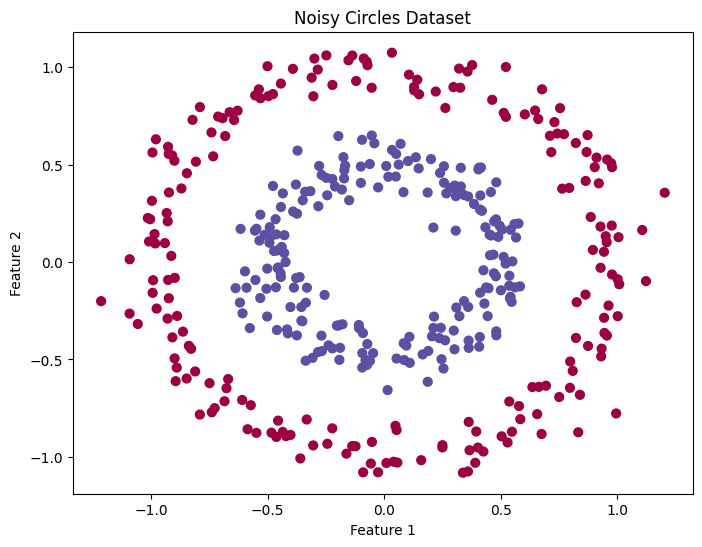

In [16]:
# Generate noisy circles dataset
noisy_circles = sklearn.datasets.make_circles(n_samples=400, factor=.5, noise=.08, random_state=1)
X, Y = noisy_circles
X = X.T  # Shape: (2, m)
Y = Y.reshape(1, -1)  # Shape: (1, m)

print("X shape:", X.shape)  # (2, 400)
print("Y shape:", Y.shape)  # (1, 400)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral)
plt.title("Noisy Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [17]:
def compute_cost(AL, Y):
    """
    Compute binary cross-entropy cost

    Arguments:
    AL -- probability vector (1, m)
    Y -- true labels (1, m)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Avoid log(0) issues
    AL = np.clip(AL, 1e-15, 1 - 1e-15)

    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

    cost = np.squeeze(cost)  # Turn [[17]] -> 17
    return cost

In [18]:
# Re-initialize parameters (for fresh start)
parameters = initialize_parameters_deep([2, 20, 10, 5, 1])

# Forward pass
AL, caches = L_model_forward(X, parameters)

# Compute initial cost (should be around 0.693 = -ln(0.5) since random init ≈ 0.5)
cost = compute_cost(AL, Y)
print("Initial cost:", cost)

Initial cost: 0.6781057507332204


In [19]:
def linear_backward(dZ, cache):
    """
    Linear part of backward propagation for a single layer

    Arguments:
    dZ -- Gradient of cost with respect to Z
    cache -- (A_prev, W, b) from forward

    Returns:
    dA_prev -- Gradient w.r.t. activation of previous layer
    dW -- Gradient w.r.t. W
    db -- Gradient w.r.t. b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [20]:
def linear_activation_backward(dA, cache, activation):
    """
    Backward for one layer (LINEAR -> ACTIVATION)

    Arguments:
    dA -- post-activation gradient
    cache -- (linear_cache, activation_cache) = ((A_prev, W, b), Z)
    activation -- "relu" or "sigmoid"

    Returns:
    dA_prev, dW, db
    """
    linear_cache, activation_cache = cache
    Z = activation_cache

    if activation == "relu":
        dZ = dA * relu_derivative(Z)  # dA * (1 if Z>0 else 0)
    elif activation == "sigmoid":
        s = sigmoid(Z)
        dZ = dA * s * (1 - s)  # sigmoid derivative

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [21]:
def L_model_backward(AL, Y, caches):
    """
    Full backward propagation

    Returns:
    grads -- dictionary with "dW1", "db1", ..., "dWL", "dbL"
    """
    grads = {}
    L = len(caches)  # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # Output layer (sigmoid)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # derivative of cost w.r.t. AL

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    # Hidden layers (ReLU)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu")
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [22]:
# Test backprop
AL, caches = L_model_forward(X, parameters)
grads = L_model_backward(AL, Y, caches)

# Check a few gradient shapes
print("dW1 shape:", grads["dW1"].shape)  # Should be (20, 2)
print("db1 shape:", grads["db1"].shape)  # (20, 1)
print("dW4 shape:", grads["dW4"].shape)  # (1, 5)

dW1 shape: (20, 2)
db1 shape: (20, 1)
dW4 shape: (1, 5)


In [23]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- dict with W1, b1, ...
    grads -- dict with dW1, db1, ...
    learning_rate -- scalar

    Returns:
    parameters -- updated parameters
    """
    L = len(parameters) // 2  # number of layers

    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]

    return parameters

In [24]:
def L_layer_model(X, Y, layer_dims, learning_rate=0.0075, num_iterations=3000, print_cost=True):
    """
    Full deep neural network training
    """
    np.random.seed(1)
    costs = []

    # Initialize
    parameters = initialize_parameters_deep(layer_dims)

    # Loop (gradient descent)
    for i in range(num_iterations):
        # Forward
        AL, caches = L_model_forward(X, parameters)

        # Cost
        cost = compute_cost(AL, Y)

        # Backward
        grads = L_model_backward(AL, Y, caches)

        # Update
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print cost every 100 iterations
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost:.6f}")
            costs.append(cost)

    # Plot cost curve
    plt.figure(figsize=(8, 5))
    plt.plot(costs)
    plt.title("Cost over Iterations")
    plt.xlabel("Iterations (x100)")
    plt.ylabel("Cost")
    plt.show()

    return parameters

Cost after iteration 0: 0.678106
Cost after iteration 100: 0.635758
Cost after iteration 200: 0.549268
Cost after iteration 300: 0.351446
Cost after iteration 400: 0.194005
Cost after iteration 500: 0.114623
Cost after iteration 600: 0.071644
Cost after iteration 700: 0.046859
Cost after iteration 800: 0.032210
Cost after iteration 900: 0.023303
Cost after iteration 1000: 0.017643
Cost after iteration 1100: 0.013863
Cost after iteration 1200: 0.011220
Cost after iteration 1300: 0.009311
Cost after iteration 1400: 0.007883
Cost after iteration 1500: 0.006781
Cost after iteration 1600: 0.005906
Cost after iteration 1700: 0.005201
Cost after iteration 1800: 0.004628
Cost after iteration 1900: 0.004155
Cost after iteration 2000: 0.003760
Cost after iteration 2100: 0.003425
Cost after iteration 2200: 0.003138
Cost after iteration 2300: 0.002891
Cost after iteration 2400: 0.002676


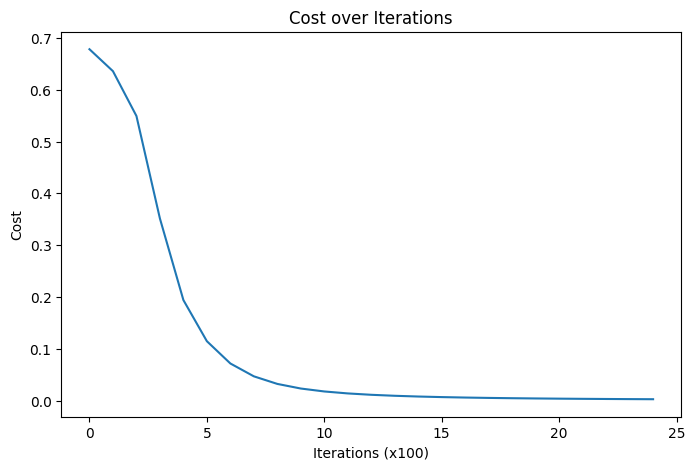

In [25]:
# Train the model
parameters = L_layer_model(X, Y, [2, 20, 10, 5, 1],
                           learning_rate=0.05,   # Higher LR for faster convergence on this dataset
                           num_iterations=2500,
                           print_cost=True)

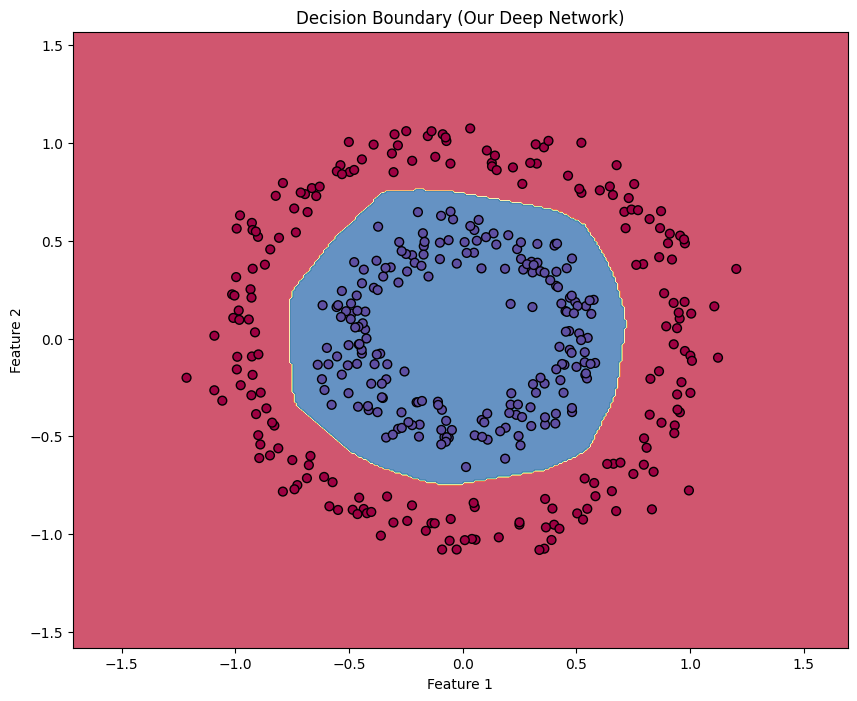

In [26]:
def predict(X, parameters):
    AL, _ = L_model_forward(X, parameters)
    predictions = (AL > 0.5).astype(int)
    return predictions

def plot_decision_boundary(X, Y, parameters):
    # Create grid
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on grid
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    Z = predict(grid_points, parameters)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("Decision Boundary (Our Deep Network)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Plot it!
plot_decision_boundary(X, Y, parameters)

In [27]:
def calculate_accuracy(X, Y, parameters):
    predictions = predict(X, parameters)
    accuracy = np.mean(predictions == Y) * 100
    return accuracy

# After training
accuracy = calculate_accuracy(X, Y, parameters)
print(f"Train Accuracy: {accuracy:.2f}%")

Train Accuracy: 100.00%


In [28]:
def predict(X, parameters):
    """
    Make predictions using the trained model

    Arguments:
    X -- input data (n_x, m)
    parameters -- trained parameters

    Returns:
    predictions -- vector of predictions (1, m) with 0 or 1
    """
    AL, _ = L_model_forward(X, parameters)
    predictions = (AL > 0.5).astype(int)  # This ensures it's 0s and 1s, shape (1, m)
    return predictions

In [29]:
def calculate_accuracy(X, Y, parameters):
    predictions = predict(X, parameters)

    # Ensure both are (1, m) and flattened for comparison
    accuracy = np.mean(predictions == Y) * 100

    print(f"Training Accuracy: {accuracy:.2f}%")
    return accuracy

In [30]:
# After your training finishes
calculate_accuracy(X, Y, parameters)

Training Accuracy: 100.00%


np.float64(100.0)

X shape: (2, 400)
Y shape: (1, 400)


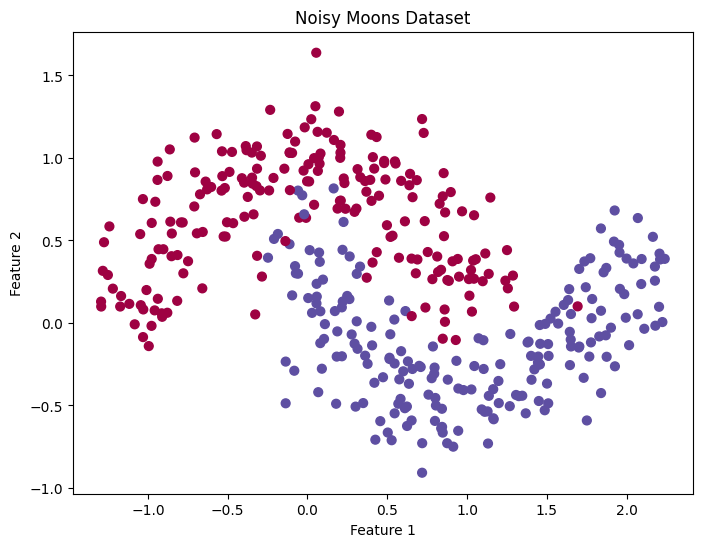

In [31]:
# Generate noisy moons dataset
noisy_moons = sklearn.datasets.make_moons(n_samples=400, noise=0.20, random_state=1)
X, Y = noisy_moons
X = X.T  # Shape: (2, m)
Y = Y.reshape(1, -1)  # Shape: (1, m)

print("X shape:", X.shape)  # (2, 400)
print("Y shape:", Y.shape)  # (1, 400)

# Plot the raw data
plt.figure(figsize=(8, 6))
plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral)
plt.title("Noisy Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Cost after iteration 0: 0.752828
Cost after iteration 100: 0.636814
Cost after iteration 200: 0.421818
Cost after iteration 300: 0.289338
Cost after iteration 400: 0.261326
Cost after iteration 500: 0.244272
Cost after iteration 600: 0.229827
Cost after iteration 700: 0.215433
Cost after iteration 800: 0.199479
Cost after iteration 900: 0.182384
Cost after iteration 1000: 0.166243
Cost after iteration 1100: 0.150176
Cost after iteration 1200: 0.135466
Cost after iteration 1300: 0.123771
Cost after iteration 1400: 0.114121
Cost after iteration 1500: 0.106323
Cost after iteration 1600: 0.100548
Cost after iteration 1700: 0.096182
Cost after iteration 1800: 0.092664
Cost after iteration 1900: 0.089577
Cost after iteration 2000: 0.086962
Cost after iteration 2100: 0.084849
Cost after iteration 2200: 0.083209
Cost after iteration 2300: 0.081782
Cost after iteration 2400: 0.080539


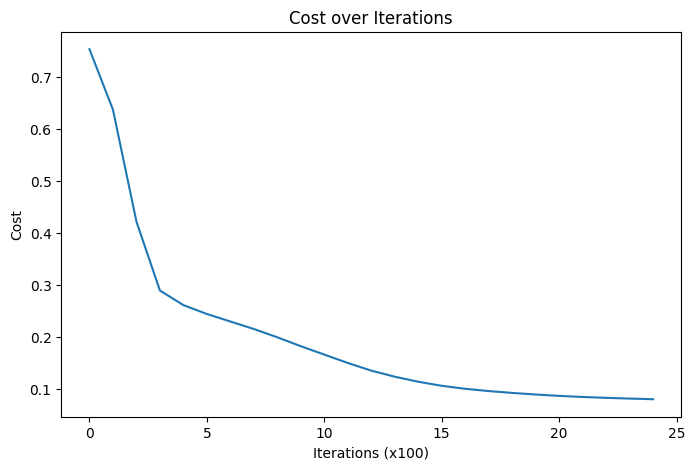

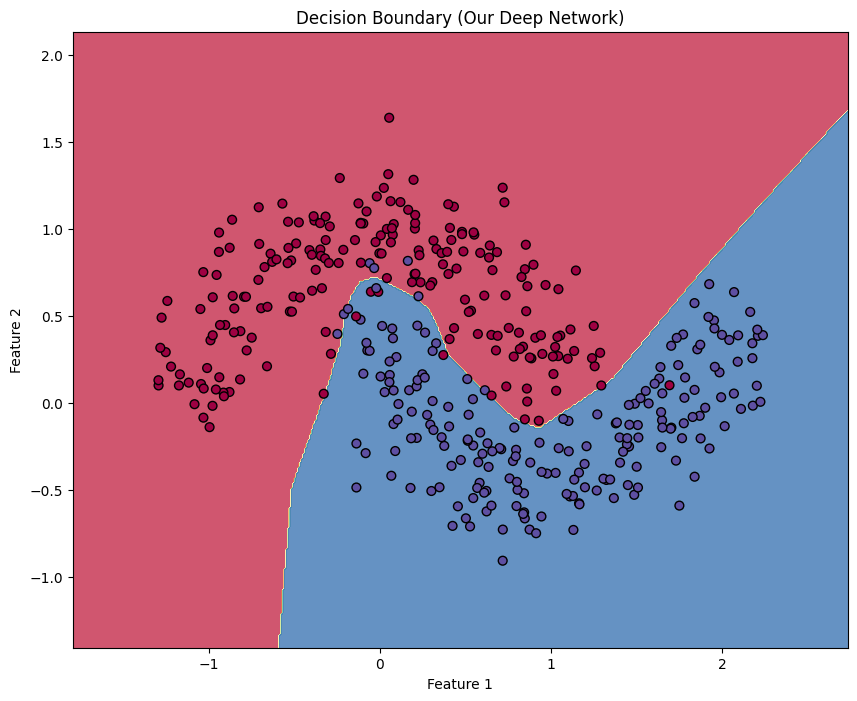

Training Accuracy: 97.00%


np.float64(97.0)

In [32]:
# Re-initialize and train
parameters = L_layer_model(X, Y, [2, 20, 10, 5, 1],
                           learning_rate=0.05,
                           num_iterations=2500,
                           print_cost=True)

# Plot the beautiful decision boundary
plot_decision_boundary(X, Y, parameters)

# Check accuracy
calculate_accuracy(X, Y, parameters)

X shape: (2, 400)
Y shape: (1, 400)


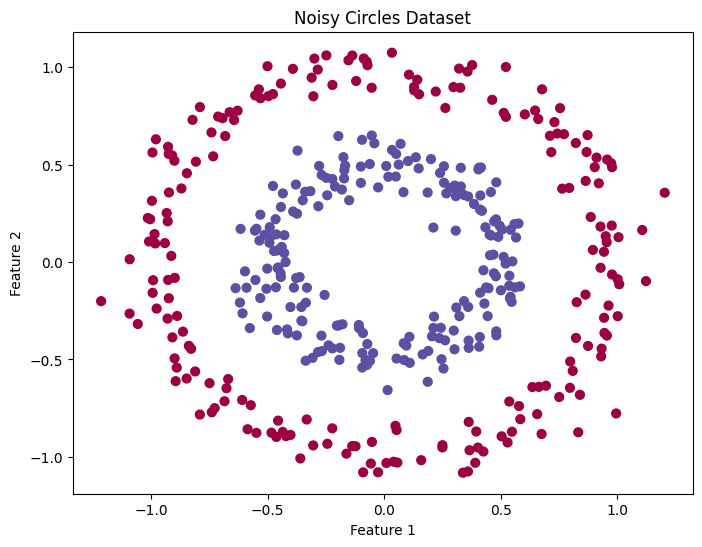

In [33]:
# Generate noisy circles dataset
noisy_circles = sklearn.datasets.make_circles(n_samples=400, factor=.5, noise=.08, random_state=1)
X, Y = noisy_circles
X = X.T  # Shape: (2, m)
Y = Y.reshape(1, -1)  # Shape: (1, m)

print("X shape:", X.shape)  # (2, 400)
print("Y shape:", Y.shape)  # (1, 400)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral)
plt.title("Noisy Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [34]:
def compute_cost(AL, Y):
    """
    Compute binary cross-entropy cost

    Arguments:
    AL -- probability vector (1, m)
    Y -- true labels (1, m)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Avoid log(0) issues
    AL = np.clip(AL, 1e-15, 1 - 1e-15)

    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

    cost = np.squeeze(cost)  # Turn [[17]] -> 17
    return cost

In [35]:
# Re-initialize parameters (for fresh start)
parameters = initialize_parameters_deep([2, 20, 10, 5, 1])

# Forward pass
AL, caches = L_model_forward(X, parameters)

# Compute initial cost (should be around 0.693 = -ln(0.5) since random init ≈ 0.5)
cost = compute_cost(AL, Y)
print("Initial cost:", cost)

Initial cost: 0.6781057507332204


In [36]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of (A_prev, W, b) coming from the forward propagation

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1)
    dW -- Gradient of the cost with respect to W (current layer l)
    db -- Gradient of the cost with respect to b (current layer l)
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [37]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of (linear_cache, activation_cache)
    activation -- "sigmoid" or "relu"

    Returns:
    dA_prev, dW, db
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [38]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID

    Arguments:
    AL -- probability vector, output of the forward propagation
    Y -- true labels (1, m)
    caches -- list of caches from forward pass

    Returns:
    grads -- dictionary with gradients dW1, db1, ..., dWL, dbL
    """
    grads = {}
    L = len(caches)  # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # Initial dAL
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = \
        linear_activation_backward(dAL, current_cache, "sigmoid")

    # Loop from l = L-2 to 0 (RELU layers)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = \
            linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [39]:
def L_layer_model(X, Y, layer_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1) -> LINEAR->SIGMOID.

    Arguments:
    X -- input data, shape (n_x, m)
    Y -- true labels, shape (1, m)
    layer_dims -- list of layer sizes, e.g., [2, 20, 10, 5, 1]
    learning_rate -- learning rate of the gradient descent
    num_iterations -- number of iterations
    print_cost -- if True, print cost every 100 iterations

    Returns:
    parameters -- learned parameters
    """
    np.random.seed(1)
    costs = []

    # Initialize parameters
    parameters = initialize_parameters_deep(layer_dims)

    # Gradient descent loop
    for i in range(0, num_iterations):

        # Forward propagation
        AL, caches = L_model_forward(X, parameters)

        # Compute cost
        cost = compute_cost(AL, Y)

        # Backward propagation
        grads = L_model_backward(AL, Y, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print cost
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
        if i % 100 == 0:
            costs.append(cost)

    # Plot the cost curve
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title(f"Learning rate = {learning_rate}")
    plt.show()

    return parameters

Cost after iteration 0: 0.6781057507332204
Cost after iteration 100: 0.6735645365809856
Cost after iteration 200: 0.6683106231473027
Cost after iteration 300: 0.6623800623284131
Cost after iteration 400: 0.6558279944905333
Cost after iteration 500: 0.6487097937211754
Cost after iteration 600: 0.6410520075732322
Cost after iteration 700: 0.6328283318499657
Cost after iteration 800: 0.6238453092983204
Cost after iteration 900: 0.6138457294910813
Cost after iteration 1000: 0.6025004035900801
Cost after iteration 1100: 0.5892928369422387
Cost after iteration 1200: 0.5736966857151371
Cost after iteration 1300: 0.5553987797067814
Cost after iteration 1400: 0.5336567387979608
Cost after iteration 1500: 0.5081615993322331
Cost after iteration 1600: 0.47918186444197114
Cost after iteration 1700: 0.447520191559867
Cost after iteration 1800: 0.41471510519827337
Cost after iteration 1900: 0.3820641209708823
Cost after iteration 2000: 0.3500964414852284
Cost after iteration 2100: 0.3200278160924891

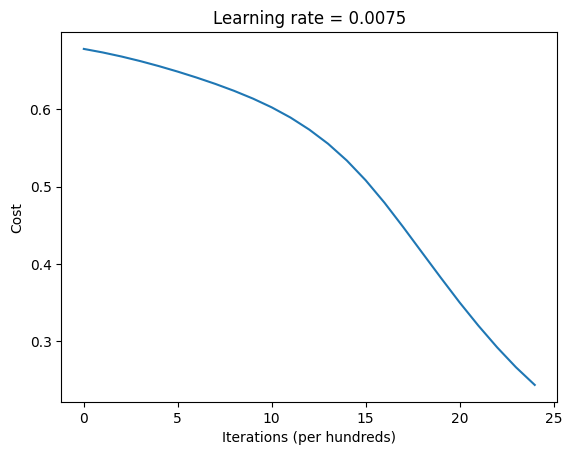

In [40]:
# Train the model
parameters = L_layer_model(X, Y, layer_dims=[2, 20, 10, 5, 1],
                           learning_rate=0.0075,
                           num_iterations=2500,
                           print_cost=True)

In [41]:
def predict(X, parameters):
    """
    Predict the results using learned parameters

    Arguments:
    X -- data (2, m)
    parameters -- trained parameters

    Returns:
    predictions -- vector of predictions (0 or 1)
    """
    AL, _ = L_model_forward(X, parameters)
    predictions = (AL > 0.5).astype(int)
    return predictions

Training accuracy: 99.50%


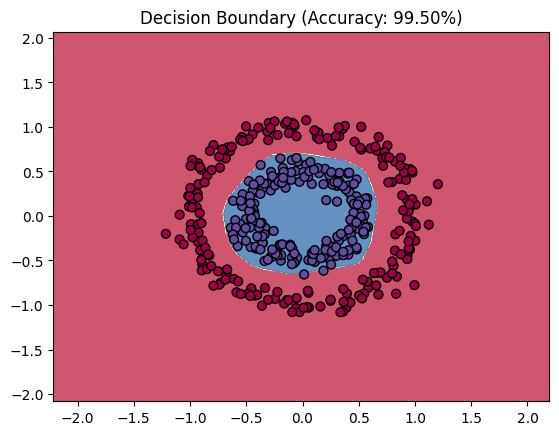

In [42]:
# Make predictions on the training set
predictions = predict(X, parameters)

# Print accuracy
accuracy = np.mean(predictions == Y) * 100
print(f"Training accuracy: {accuracy:.2f}%")

# Plot the decision boundary
plt.title("Model with learned decision boundary")
plt.scatter(X[0, :], X[1, :], c=np.squeeze(predictions), s=40, cmap=plt.cm.Spectral)

# To make it even prettier: plot the full colored boundary
# Create a grid of points
h = 0.01
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on the entire grid
grid_points = np.c_[xx.ravel(), yy.ravel()].T  # shape (2, num_points)
Z = predict(grid_points, parameters)
Z = Z.reshape(xx.shape)

# Plot contour (the colored regions)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
# Overlay the training points
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral, edgecolors='black')
plt.title(f"Decision Boundary (Accuracy: {accuracy:.2f}%)")
plt.show()